# MNIST Classification Method Comparison

This notebook will demonstrate different ways for MNIST classification:
- Builds a simple, a deeper, and a ResNet Style, and Multi Layer Perceptron Style NN
- Compares and evaluates their accuracy

## 1. Setup and Configuration

In [3]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

C:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


## 2. Data Loading and Preprocessing

We'll load the MNIST dataset with proper train/validation/test splits and apply standard preprocessing.

In [4]:
# Data loading function
def load_mnist_data(batch_size=128):
    """Load and preprocess MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load datasets
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )
    
    # Split train into train and validation (80/20 split)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    
    # Print dataset statistics
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Batch size: {batch_size}")
    
    return train_loader, val_loader, test_loader

# Load the data
print("Loading MNIST dataset...")
train_loader, val_loader, test_loader = load_mnist_data(batch_size=128)

Loading MNIST dataset...


100.0%
100.0%
100.0%
100.0%

Training samples: 48000
Validation samples: 12000
Test samples: 10000
Batch size: 128



Visualizing sample images:


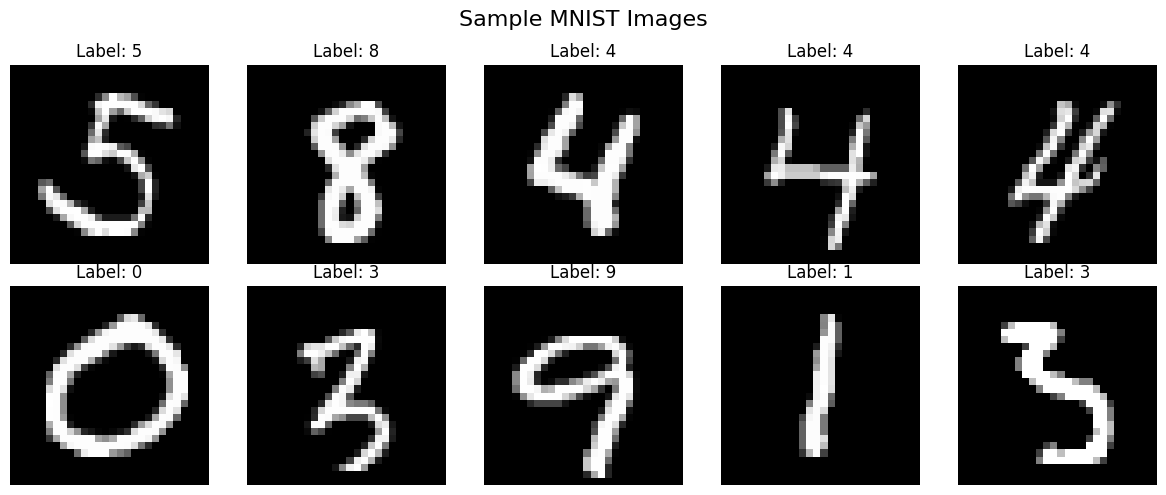

In [5]:
# Visualize sample images from the dataset
def visualize_dataset_samples(loader, num_samples=10):
    """Display sample images from the dataset"""
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    
    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    
    plt.suptitle('Sample MNIST Images', fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nVisualizing sample images:")
visualize_dataset_samples(train_loader)

## 3. Model Architectures

We'll implement four different neural network architectures to compare their performance.

### 3.1 Simple CNN

In [7]:
class SimpleCNN(nn.Module):
    """Simple CNN baseline model for MNIST classification"""
    def __init__(self, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate)
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Test the model
sample_model = SimpleCNN()
sample_input = torch.randn(4, 1, 28, 28)
sample_output = sample_model(sample_input)
print(f"SimpleCNN output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in sample_model.parameters()):,}")

SimpleCNN output shape: torch.Size([4, 10])
Model parameters: 421,642


### 3.2 Deep CNN with Batch Normalization

In [8]:
class DeepCNN(nn.Module):
    """Deeper CNN architecture with batch normalization"""
    def __init__(self, dropout_rate=0.4):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(dropout_rate)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Test the model
sample_model = DeepCNN()
sample_output = sample_model(sample_input)
print(f"DeepCNN output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in sample_model.parameters()):,}")

DeepCNN output shape: torch.Size([4, 10])
Model parameters: 903,402


### 3.3 ResNet-inspired Architecture

In [9]:
class ResidualBlock(nn.Module):
    """Residual block for ResNet-like architecture"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResNetLike(nn.Module):
    """ResNet-inspired architecture for MNIST"""
    def __init__(self):
        super(ResNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks
        self.layer1 = self._make_layer(32, 32, 2, stride=1)
        self.layer2 = self._make_layer(32, 64, 2, stride=2)
        self.layer3 = self._make_layer(64, 128, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Test the model
sample_model = ResNetLike()
sample_output = sample_model(sample_input)
print(f"ResNetLike output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in sample_model.parameters()):,}")

ResNetLike output shape: torch.Size([4, 10])
Model parameters: 696,042


### Multi-layer Perception

In [10]:
class SimpleMLP(nn.Module):
    """Simple Multi-Layer Perceptron for comparison"""
    def __init__(self, hidden_sizes=[512, 256], dropout=0.3):
        super(SimpleMLP, self).__init__()
        layers = []
        input_size = 28 * 28
        
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            layers.append(nn.BatchNorm1d(hidden_size))
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, 10))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)

# Test the model
sample_model = SimpleMLP()
sample_output = sample_model(sample_input)
print(f"SimpleMLP output shape: {sample_output.shape}")
print(f"Model parameters: {sum(p.numel() for p in sample_model.parameters()):,}")

SimpleMLP output shape: torch.Size([4, 10])
Model parameters: 537,354


In [12]:
#Model Factory
def create_model(model_name, config=None):
    """Factory function to create different model configurations"""
    if config is None:
        config = {}
    
    models = {
        'simple_cnn': lambda: SimpleCNN(dropout_rate=config.get('dropout', 0.3)),
        'deep_cnn': lambda: DeepCNN(dropout_rate=config.get('dropout', 0.4)),
        'resnet': lambda: ResNetLike(),
        'mlp': lambda: SimpleMLP(
            hidden_sizes=config.get('hidden_sizes', [512, 256]),
            dropout=config.get('dropout', 0.3)
        )
    }
    
    if model_name not in models:
        raise ValueError(f"Model {model_name} not supported")
    
    return models[model_name]()

# Test model factory
print("\nTesting model factory:")
for model_name in ['simple_cnn', 'deep_cnn', 'resnet', 'mlp']:
    model = create_model(model_name)
    print(f"{model_name}: {sum(p.numel() for p in model.parameters()):,} parameters")


Testing model factory:
simple_cnn: 421,642 parameters
deep_cnn: 903,402 parameters
resnet: 696,042 parameters
mlp: 537,354 parameters


## 4. Training Utilities

We'll create a comprehensive training class that handles training loops, validation, and metrics tracking.

In [13]:
class ModelTrainer:
    """Handles training and evaluation of PyTorch models"""
    
    def __init__(self, model, device, writer=None):
        self.model = model.to(device)
        self.device = device
        self.writer = writer
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        
    def train_epoch(self, train_loader, optimizer, criterion, scheduler=None):
        """Train model for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Log to tensorboard
            if self.writer is not None:
                global_step = len(self.train_losses) * len(train_loader) + batch_idx
                self.writer.add_scalar('Batch/Loss', loss.item(), global_step)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader, criterion):
        """Validate model on validation set"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        return val_loss, val_acc
    
    def train(self, train_loader, val_loader, epochs, optimizer, criterion, 
              scheduler=None, early_stopping_patience=10):
        """Full training loop with early stopping"""
        best_val_acc = 0
        patience_counter = 0
        best_model_state = None
        
        print(f"\nStarting training for {epochs} epochs...")
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Train for one epoch
            train_loss, train_acc = self.train_epoch(
                train_loader, optimizer, criterion, scheduler
            )
            
            # Validate
            val_loss, val_acc = self.validate(val_loader, criterion)
            
            # Update learning rate scheduler
            if scheduler is not None:
                scheduler.step(val_loss)
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
            
            # Log to tensorboard
            if self.writer is not None:
                self.writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
                self.writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
            
            # Early stopping and model checkpoint
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0
                # Save checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                }, 'best_model_checkpoint.pth')
            else:
                patience_counter += 1
            
            # Print progress
            elapsed = time.time() - start_time
            print(f'Epoch [{epoch+1}/{epochs}] - Time: {elapsed:.2f}s')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            
            if patience_counter >= early_stopping_patience:
                print(f'\nEarly stopping triggered at epoch {epoch+1}')
                break
        
        # Load best model weights
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
        
        return best_val_acc
    
    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        all_preds = []
        all_targets = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        accuracy = 100. * correct / total
        return accuracy, np.array(all_preds), np.array(all_targets)
    
    def plot_training_history(self, model_name="Model"):
        """Plot training and validation metrics"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot losses
        axes[0].plot(self.train_losses, label='Train Loss', linewidth=2)
        axes[0].plot(self.val_losses, label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].set_title(f'{model_name} - Training and Validation Loss')
        axes[0].grid(True, alpha=0.3)
        
        # Plot accuracies
        axes[1].plot(self.train_accs, label='Train Accuracy', linewidth=2)
        axes[1].plot(self.val_accs, label='Val Accuracy', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].legend()
        axes[1].set_title(f'{model_name} - Training and Validation Accuracy')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 5. Model Comparison Framework

We'll create a framework to systematically compare different model configurations.|

In [19]:
class ModelComparator:
    """Framework for comparing different model configurations"""
    
    def __init__(self):
        self.results = {}
        self.experiment_history = []
        
    def run_experiment(self, model_name, model_config, train_config, 
                   train_loader, val_loader, test_loader,
                   experiment_name=None):
        """Run a complete experiment with given configuration"""
        if experiment_name is None:
            experiment_name = f"{model_name}_{len(self.results)}"
        
        print(f"\n{'='*60}")
        print(f"Experiment: {experiment_name}")
        print(f"Model: {model_name}")
        print(f"Config: {model_config}")
        print(f"{'='*60}")
        
        # Create model and count parameters
        model = create_model(model_name, model_config)
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        # Initialize tensorboard writer
        writer = SummaryWriter(f'runs/{experiment_name}_{time.strftime("%Y%m%d-%H%M%S")}')
        
        # Create trainer
        trainer = ModelTrainer(model, device, writer)
        
        # Setup optimizer and scheduler
        optimizer = optim.Adam(
            model.parameters(), 
            lr=train_config['lr'],
            weight_decay=train_config.get('weight_decay', 1e-4)
        )
        
        # FIXED: Remove 'verbose' parameter from ReduceLROnPlateau
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        
        criterion = nn.CrossEntropyLoss()
        
        # Train model
        start_time = time.time()
        best_val_acc = trainer.train(
            train_loader, val_loader,
            epochs=train_config['epochs'],
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            early_stopping_patience=train_config.get('early_stopping_patience', 10)
        )
        training_time = time.time() - start_time
        
        # Evaluate on test set
        test_acc, predictions, targets = trainer.evaluate(test_loader)
        
        # Store results
        result = {
            'experiment_name': experiment_name,
            'model_name': model_name,
            'model_config': model_config,
            'train_config': train_config,
            'best_val_acc': best_val_acc,
            'test_acc': test_acc,
            'training_time': training_time,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'trainer': trainer,
            'predictions': predictions,
            'targets': targets,
            'model': model
        }
        
        self.results[experiment_name] = result
        self.experiment_history.append(experiment_name)
        
        print(f"\nExperiment {experiment_name} completed:")
        print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
        print(f"  Test Accuracy: {test_acc:.2f}%")
        print(f"  Training Time: {training_time:.2f}s")
        
        writer.close()
        return result
    
    def plot_comparison(self):
        """Create comprehensive comparison plots"""
        if not self.results:
            print("No experiments to compare")
            return
        
        # Prepare comparison data
        comparison_data = []
        for exp_name, result in self.results.items():
            comparison_data.append({
                'Experiment': exp_name,
                'Model': result['model_name'],
                'Test Accuracy (%)': result['test_acc'],
                'Validation Accuracy (%)': result['best_val_acc'],
                'Training Time (s)': result['training_time'],
                'Parameters (M)': result['total_params'] / 1e6,
                'Trainable Parameters (M)': result['trainable_params'] / 1e6
            })
        
        df = pd.DataFrame(comparison_data)
        
        # Create comprehensive comparison plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Accuracy comparison
        ax = axes[0, 0]
        x = np.arange(len(df))
        width = 0.35
        ax.bar(x - width/2, df['Validation Accuracy (%)'], width, 
               label='Validation', color='skyblue', alpha=0.8)
        ax.bar(x + width/2, df['Test Accuracy (%)'], width, 
               label='Test', color='lightcoral', alpha=0.8)
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title('Model Accuracy Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(df['Experiment'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add accuracy values on bars
        for i, (val_acc, test_acc) in enumerate(zip(df['Validation Accuracy (%)'], 
                                                    df['Test Accuracy (%)'])):
            ax.text(i - width/2, val_acc + 0.2, f'{val_acc:.2f}', 
                   ha='center', va='bottom', fontsize=9)
            ax.text(i + width/2, test_acc + 0.2, f'{test_acc:.2f}', 
                   ha='center', va='bottom', fontsize=9)
        
        # 2. Parameter efficiency
        ax = axes[0, 1]
        colors = plt.cm.Set3(np.linspace(0, 1, len(df)))
        scatter = ax.scatter(df['Parameters (M)'], df['Test Accuracy (%)'], 
                            s=200, c=colors, alpha=0.7, edgecolors='black')
        
        for i, row in df.iterrows():
            ax.annotate(row['Experiment'], 
                       (row['Parameters (M)'], row['Test Accuracy (%)']),
                       xytext=(5, 5), textcoords='offset points', 
                       fontsize=9, fontweight='bold')
        
        ax.set_xlabel('Number of Parameters (M)')
        ax.set_ylabel('Test Accuracy (%)')
        ax.set_title('Parameter Efficiency')
        ax.grid(True, alpha=0.3)
        
        # 3. Training time comparison
        ax = axes[0, 2]
        bars = ax.bar(df['Experiment'], df['Training Time (s)'], 
                     color=plt.cm.viridis(np.linspace(0, 1, len(df))))
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Training Time (s)')
        ax.set_title('Training Time Comparison')
        ax.set_xticklabels(df['Experiment'], rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add time values on bars
        for bar, time_val in zip(bars, df['Training Time (s)']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(df['Training Time (s)'])*0.01,
                   f'{time_val:.1f}s', ha='center', va='bottom', fontsize=9)
        
        # 4. Confusion matrix for best model
        ax = axes[1, 0]
        best_exp = df.loc[df['Test Accuracy (%)'].idxmax(), 'Experiment']
        best_result = self.results[best_exp]
        
        cm = confusion_matrix(best_result['targets'], best_result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=ax, 
                   cbar_kws={'label': 'Count'})
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_title(f'Confusion Matrix: {best_exp}')
        
        # 5. Training history for best model
        ax = axes[1, 1]
        best_trainer = best_result['trainer']
        epochs = range(1, len(best_trainer.train_losses) + 1)
        
        ax.plot(epochs, best_trainer.train_losses, 'b-', label='Train Loss', linewidth=2)
        ax.plot(epochs, best_trainer.val_losses, 'r-', label='Val Loss', linewidth=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Training History: {best_exp}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 6. Accuracy vs Parameters scatter with model type
        ax = axes[1, 2]
        model_types = df['Model'].unique()
        colors = plt.cm.tab10(range(len(model_types)))
        
        for model_type, color in zip(model_types, colors):
            mask = df['Model'] == model_type
            ax.scatter(df[mask]['Parameters (M)'], 
                      df[mask]['Test Accuracy (%)'],
                      s=150, c=[color], label=model_type, alpha=0.7,
                      edgecolors='black')
        
        ax.set_xlabel('Parameters (M)')
        ax.set_ylabel('Test Accuracy (%)')
        ax.set_title('Accuracy vs Parameters by Model Type')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed comparison table
        print("\n" + "="*80)
        print("MODEL COMPARISON SUMMARY")
        print("="*80)
        print(df.to_string(index=False))
        
        # Print best model details
        print("\n" + "="*80)
        print("BEST MODEL DETAILS")
        print("="*80)
        print(f"Best Experiment: {best_exp}")
        print(f"Model Type: {best_result['model_name']}")
        print(f"Test Accuracy: {best_result['test_acc']:.2f}%")
        print(f"Total Parameters: {best_result['total_params']:,}")
        
        # Print classification report
        print("\nClassification Report:")
        print("-"*60)
        print(classification_report(
            best_result['targets'], 
            best_result['predictions'],
            target_names=[str(i) for i in range(10)]
        ))
        
        return df
    
    def plot_model_performance_by_type(self):
        """Plot performance comparison by model type"""
        if not self.results:
            print("No experiments to compare")
            return
        
        # Group results by model type
        model_type_data = {}
        for exp_name, result in self.results.items():
            model_type = result['model_name']
            if model_type not in model_type_data:
                model_type_data[model_type] = []
            model_type_data[model_type].append(result['test_acc'])
        
        # Create box plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        model_types = list(model_type_data.keys())
        accuracies = [model_type_data[mt] for mt in model_types]
        
        bp = ax.boxplot(accuracies, patch_artist=True, labels=model_types)
        
        # Color the boxes
        colors = plt.cm.Set2(np.linspace(0, 1, len(model_types)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_ylabel('Test Accuracy (%)')
        ax.set_title('Test Accuracy Distribution by Model Type')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add mean values
        for i, accs in enumerate(accuracies, 1):
            mean_acc = np.mean(accs)
            ax.text(i, mean_acc + 0.1, f'{mean_acc:.2f}%', 
                   ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

## 6. Main Experiments

Now let's run experiments with different model configurations to compare their performance.

Starting model comparison experiments...

Experiment: simple_cnn
Model: simple_cnn
Config: {'dropout': 0.3}
Total parameters: 421,642
Trainable parameters: 421,642

Starting training for 30 epochs...
Epoch [1/30] - Time: 13.09s
  Train Loss: 0.2464, Train Acc: 92.23%
  Val Loss: 0.0706, Val Acc: 97.89%
Epoch [2/30] - Time: 11.53s
  Train Loss: 0.0833, Train Acc: 97.50%
  Val Loss: 0.0566, Val Acc: 98.28%
Epoch [3/30] - Time: 11.35s
  Train Loss: 0.0659, Train Acc: 97.97%
  Val Loss: 0.0511, Val Acc: 98.50%
Epoch [4/30] - Time: 11.30s
  Train Loss: 0.0524, Train Acc: 98.40%
  Val Loss: 0.0406, Val Acc: 98.78%
Epoch [5/30] - Time: 11.25s
  Train Loss: 0.0444, Train Acc: 98.62%
  Val Loss: 0.0443, Val Acc: 98.65%
Epoch [6/30] - Time: 11.47s
  Train Loss: 0.0421, Train Acc: 98.68%
  Val Loss: 0.0357, Val Acc: 98.92%
Epoch [7/30] - Time: 12.05s
  Train Loss: 0.0374, Train Acc: 98.84%
  Val Loss: 0.0367, Val Acc: 98.90%
Epoch [8/30] - Time: 12.30s
  Train Loss: 0.0362, Train Acc: 98.82%
  Va

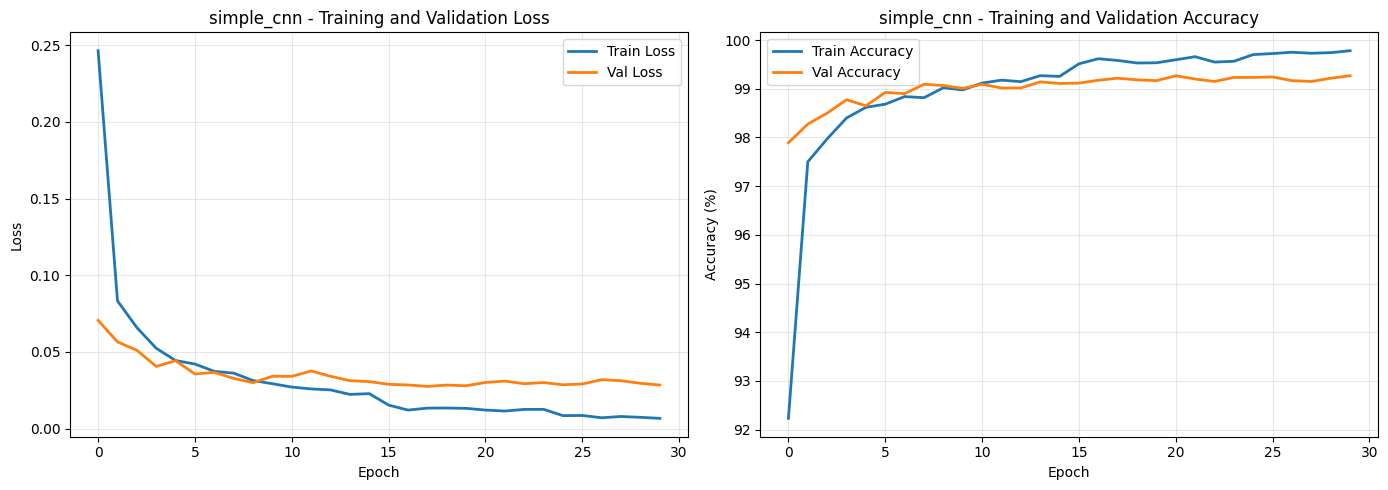


Experiment: simple_cnn_no_dropout
Model: simple_cnn
Config: {'dropout': 0.0}
Total parameters: 421,642
Trainable parameters: 421,642

Starting training for 30 epochs...
Epoch [1/30] - Time: 11.34s
  Train Loss: 0.1911, Train Acc: 94.15%
  Val Loss: 0.0757, Val Acc: 97.67%
Epoch [2/30] - Time: 11.64s
  Train Loss: 0.0533, Train Acc: 98.35%
  Val Loss: 0.0534, Val Acc: 98.35%
Epoch [3/30] - Time: 11.28s
  Train Loss: 0.0362, Train Acc: 98.91%
  Val Loss: 0.0459, Val Acc: 98.56%
Epoch [4/30] - Time: 11.42s
  Train Loss: 0.0265, Train Acc: 99.14%
  Val Loss: 0.0400, Val Acc: 98.73%
Epoch [5/30] - Time: 11.42s
  Train Loss: 0.0212, Train Acc: 99.28%
  Val Loss: 0.0392, Val Acc: 98.65%
Epoch [6/30] - Time: 11.32s
  Train Loss: 0.0167, Train Acc: 99.48%
  Val Loss: 0.0374, Val Acc: 98.88%
Epoch [7/30] - Time: 11.22s
  Train Loss: 0.0151, Train Acc: 99.52%
  Val Loss: 0.0379, Val Acc: 98.84%
Epoch [8/30] - Time: 11.20s
  Train Loss: 0.0135, Train Acc: 99.54%
  Val Loss: 0.0389, Val Acc: 98.78

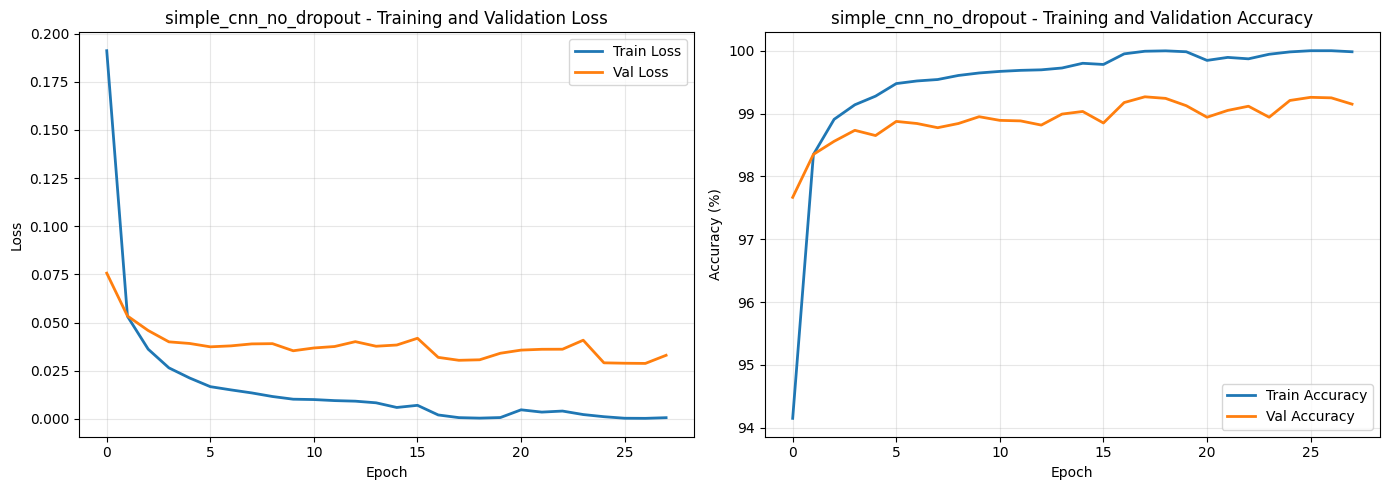


Experiment: deep_cnn
Model: deep_cnn
Config: {'dropout': 0.4}
Total parameters: 903,402
Trainable parameters: 903,402

Starting training for 30 epochs...
Epoch [1/30] - Time: 11.66s
  Train Loss: 0.1967, Train Acc: 94.58%
  Val Loss: 0.0606, Val Acc: 98.08%
Epoch [2/30] - Time: 11.58s
  Train Loss: 0.0676, Train Acc: 97.94%
  Val Loss: 0.0382, Val Acc: 98.88%
Epoch [3/30] - Time: 11.61s
  Train Loss: 0.0525, Train Acc: 98.46%
  Val Loss: 0.0326, Val Acc: 99.01%
Epoch [4/30] - Time: 11.57s
  Train Loss: 0.0427, Train Acc: 98.74%
  Val Loss: 0.0321, Val Acc: 99.03%
Epoch [5/30] - Time: 11.64s
  Train Loss: 0.0393, Train Acc: 98.78%
  Val Loss: 0.0272, Val Acc: 99.12%
Epoch [6/30] - Time: 11.79s
  Train Loss: 0.0353, Train Acc: 98.93%
  Val Loss: 0.0258, Val Acc: 99.22%
Epoch [7/30] - Time: 11.73s
  Train Loss: 0.0325, Train Acc: 98.99%
  Val Loss: 0.0287, Val Acc: 99.17%
Epoch [8/30] - Time: 11.57s
  Train Loss: 0.0309, Train Acc: 99.05%
  Val Loss: 0.0292, Val Acc: 99.11%
Epoch [9/30] 

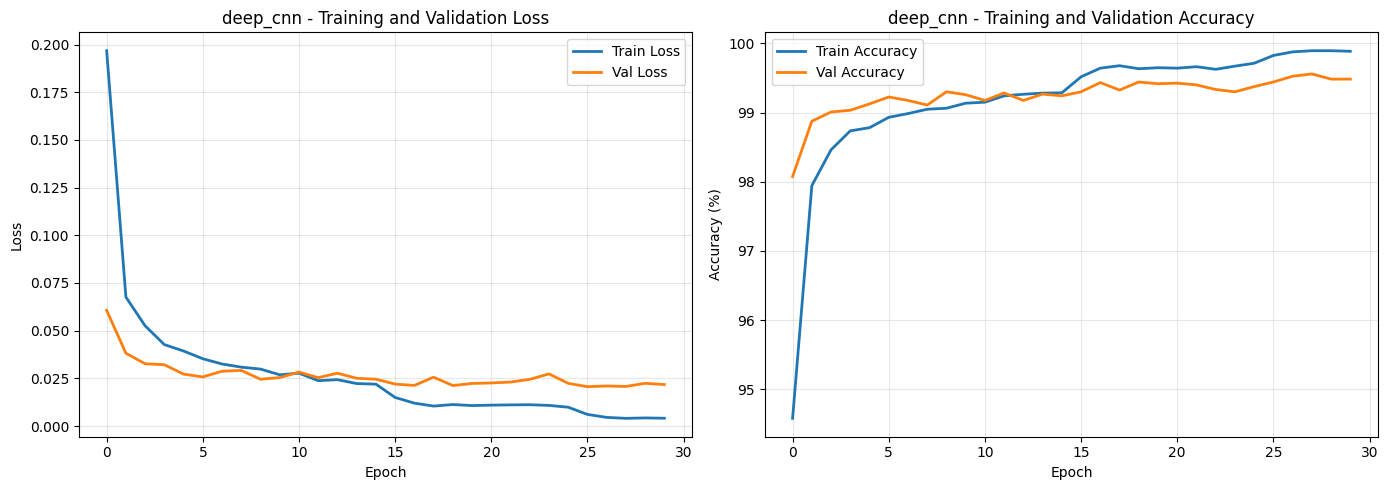


Experiment: resnet
Model: resnet
Config: {}
Total parameters: 696,042
Trainable parameters: 696,042

Starting training for 30 epochs...
Epoch [1/30] - Time: 13.89s
  Train Loss: 0.1506, Train Acc: 96.03%
  Val Loss: 0.0872, Val Acc: 97.17%
Epoch [2/30] - Time: 13.62s
  Train Loss: 0.0423, Train Acc: 98.72%
  Val Loss: 0.0714, Val Acc: 97.83%
Epoch [3/30] - Time: 13.73s
  Train Loss: 0.0335, Train Acc: 98.96%
  Val Loss: 0.0274, Val Acc: 99.16%
Epoch [4/30] - Time: 13.61s
  Train Loss: 0.0299, Train Acc: 99.11%
  Val Loss: 0.0568, Val Acc: 98.21%
Epoch [5/30] - Time: 13.60s
  Train Loss: 0.0260, Train Acc: 99.23%
  Val Loss: 0.0285, Val Acc: 99.15%
Epoch [6/30] - Time: 13.60s
  Train Loss: 0.0208, Train Acc: 99.37%
  Val Loss: 0.0449, Val Acc: 98.53%
Epoch [7/30] - Time: 13.51s
  Train Loss: 0.0220, Train Acc: 99.31%
  Val Loss: 0.0365, Val Acc: 98.83%
Epoch [8/30] - Time: 13.64s
  Train Loss: 0.0190, Train Acc: 99.45%
  Val Loss: 0.0247, Val Acc: 99.17%
Epoch [9/30] - Time: 13.57s
  T

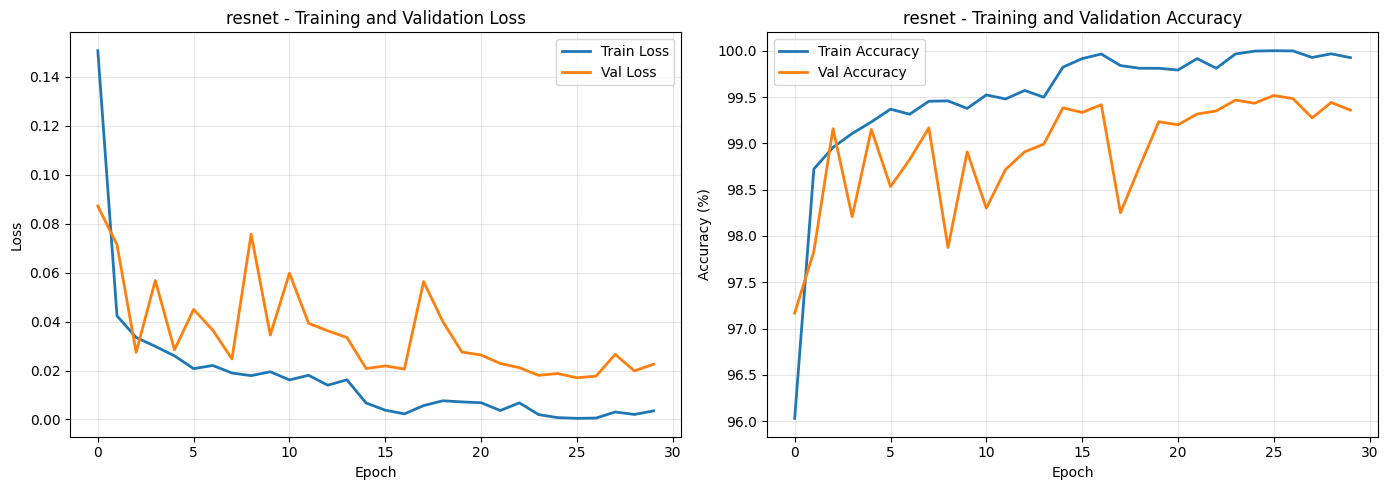


Experiment: mlp_small
Model: mlp
Config: {'hidden_sizes': [256, 128], 'dropout': 0.3}
Total parameters: 235,914
Trainable parameters: 235,914

Starting training for 30 epochs...
Epoch [1/30] - Time: 11.16s
  Train Loss: 0.3468, Train Acc: 90.42%
  Val Loss: 0.1529, Val Acc: 95.42%
Epoch [2/30] - Time: 11.15s
  Train Loss: 0.1730, Train Acc: 94.85%
  Val Loss: 0.1161, Val Acc: 96.42%
Epoch [3/30] - Time: 11.49s
  Train Loss: 0.1393, Train Acc: 95.71%
  Val Loss: 0.1127, Val Acc: 96.35%
Epoch [4/30] - Time: 11.20s
  Train Loss: 0.1239, Train Acc: 96.19%
  Val Loss: 0.0988, Val Acc: 96.97%
Epoch [5/30] - Time: 11.17s
  Train Loss: 0.1155, Train Acc: 96.48%
  Val Loss: 0.0902, Val Acc: 97.14%
Epoch [6/30] - Time: 11.15s
  Train Loss: 0.1025, Train Acc: 96.83%
  Val Loss: 0.0900, Val Acc: 97.19%
Epoch [7/30] - Time: 11.16s
  Train Loss: 0.0988, Train Acc: 96.90%
  Val Loss: 0.0865, Val Acc: 97.32%
Epoch [8/30] - Time: 11.18s
  Train Loss: 0.0939, Train Acc: 97.06%
  Val Loss: 0.0861, Val A

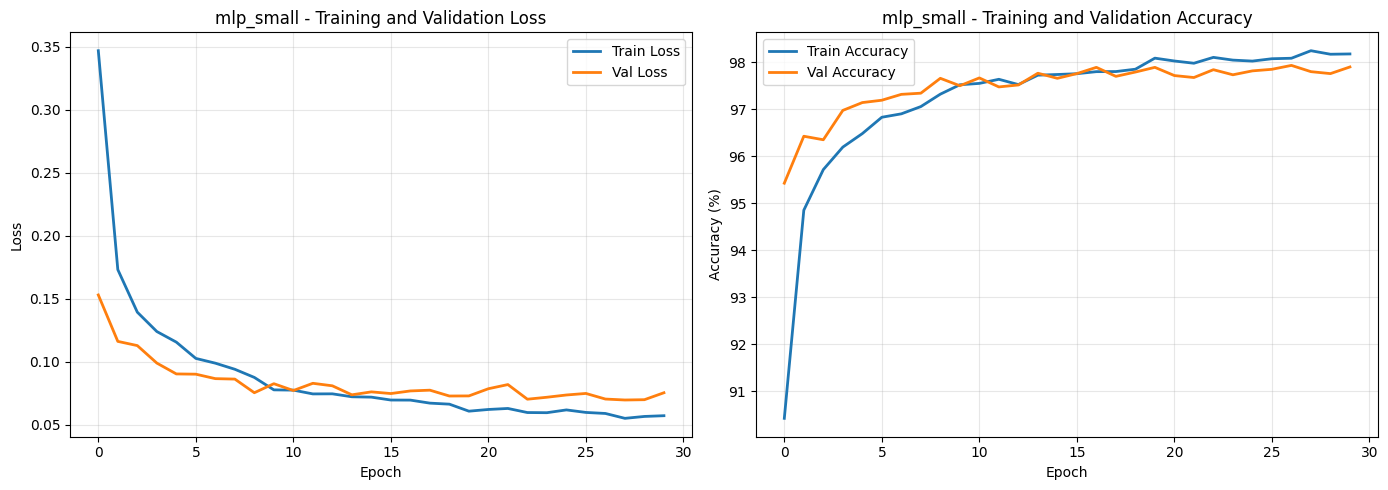


Experiment: mlp_large
Model: mlp
Config: {'hidden_sizes': [512, 256, 128], 'dropout': 0.3}
Total parameters: 569,226
Trainable parameters: 569,226

Starting training for 30 epochs...
Epoch [1/30] - Time: 11.51s
  Train Loss: 0.3452, Train Acc: 90.27%
  Val Loss: 0.1443, Val Acc: 95.56%
Epoch [2/30] - Time: 11.33s
  Train Loss: 0.1793, Train Acc: 94.62%
  Val Loss: 0.1122, Val Acc: 96.72%
Epoch [3/30] - Time: 11.65s
  Train Loss: 0.1424, Train Acc: 95.65%
  Val Loss: 0.1070, Val Acc: 96.76%
Epoch [4/30] - Time: 11.38s
  Train Loss: 0.1270, Train Acc: 96.08%
  Val Loss: 0.1058, Val Acc: 96.80%
Epoch [5/30] - Time: 11.75s
  Train Loss: 0.1123, Train Acc: 96.59%
  Val Loss: 0.0975, Val Acc: 97.03%
Epoch [6/30] - Time: 11.34s
  Train Loss: 0.1069, Train Acc: 96.68%
  Val Loss: 0.1119, Val Acc: 96.97%
Epoch [7/30] - Time: 11.28s
  Train Loss: 0.1029, Train Acc: 96.85%
  Val Loss: 0.0910, Val Acc: 97.43%
Epoch [8/30] - Time: 11.84s
  Train Loss: 0.0952, Train Acc: 97.11%
  Val Loss: 0.0854, 

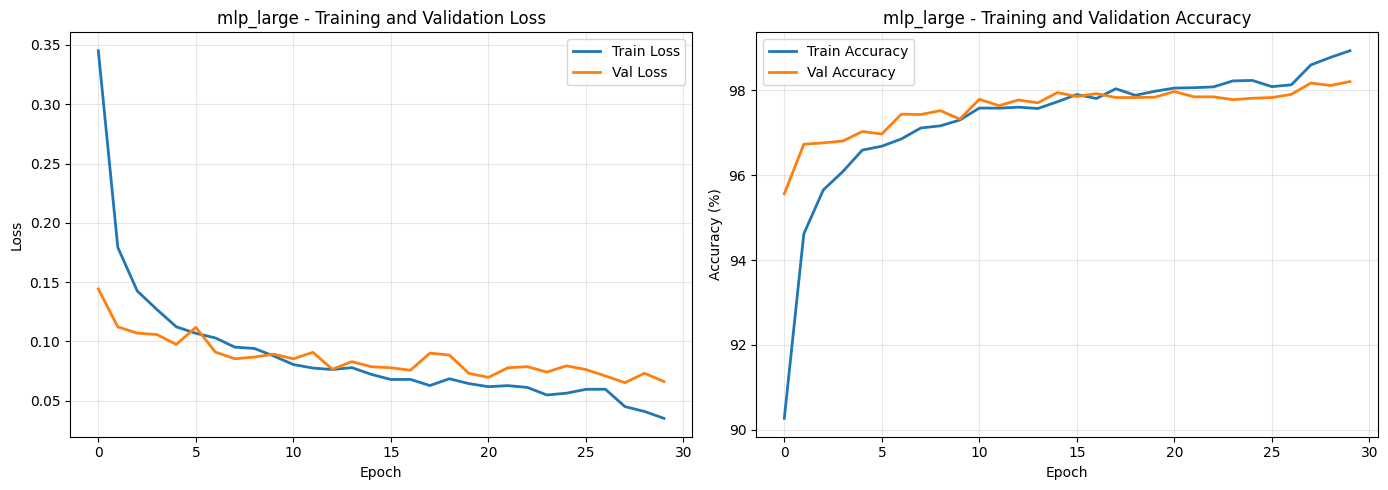

In [20]:
# Define model configurations
model_configs = {
    'simple_cnn': {'dropout': 0.3},
    'simple_cnn_no_dropout': {'dropout': 0.0},
    'deep_cnn': {'dropout': 0.4},
    'resnet': {},  # Default config
    'mlp_small': {'hidden_sizes': [256, 128], 'dropout': 0.3},
    'mlp_large': {'hidden_sizes': [512, 256, 128], 'dropout': 0.3}
}

# Training configuration
train_config = {
    'lr': 0.001,
    'epochs': 30,
    'weight_decay': 1e-4,
    'early_stopping_patience': 10
}

# Initialize comparator
comparator = ModelComparator()

# Run experiments
print("Starting model comparison experiments...")
print("="*60)

for model_name, model_config in model_configs.items():
    # Determine base model type
    base_model = 'simple_cnn' if 'simple_cnn' in model_name else \
                'deep_cnn' if 'deep_cnn' in model_name else \
                'resnet' if 'resnet' in model_name else 'mlp'
    
    result = comparator.run_experiment(
        model_name=base_model,
        model_config=model_config,
        train_config=train_config,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        experiment_name=model_name
    )
    
    # Plot training history for each experiment
    result['trainer'].plot_training_history(model_name)

## 7. Results Analysis

Let's analyze and compare the results from all experiments.


Generating comprehensive comparison analysis...


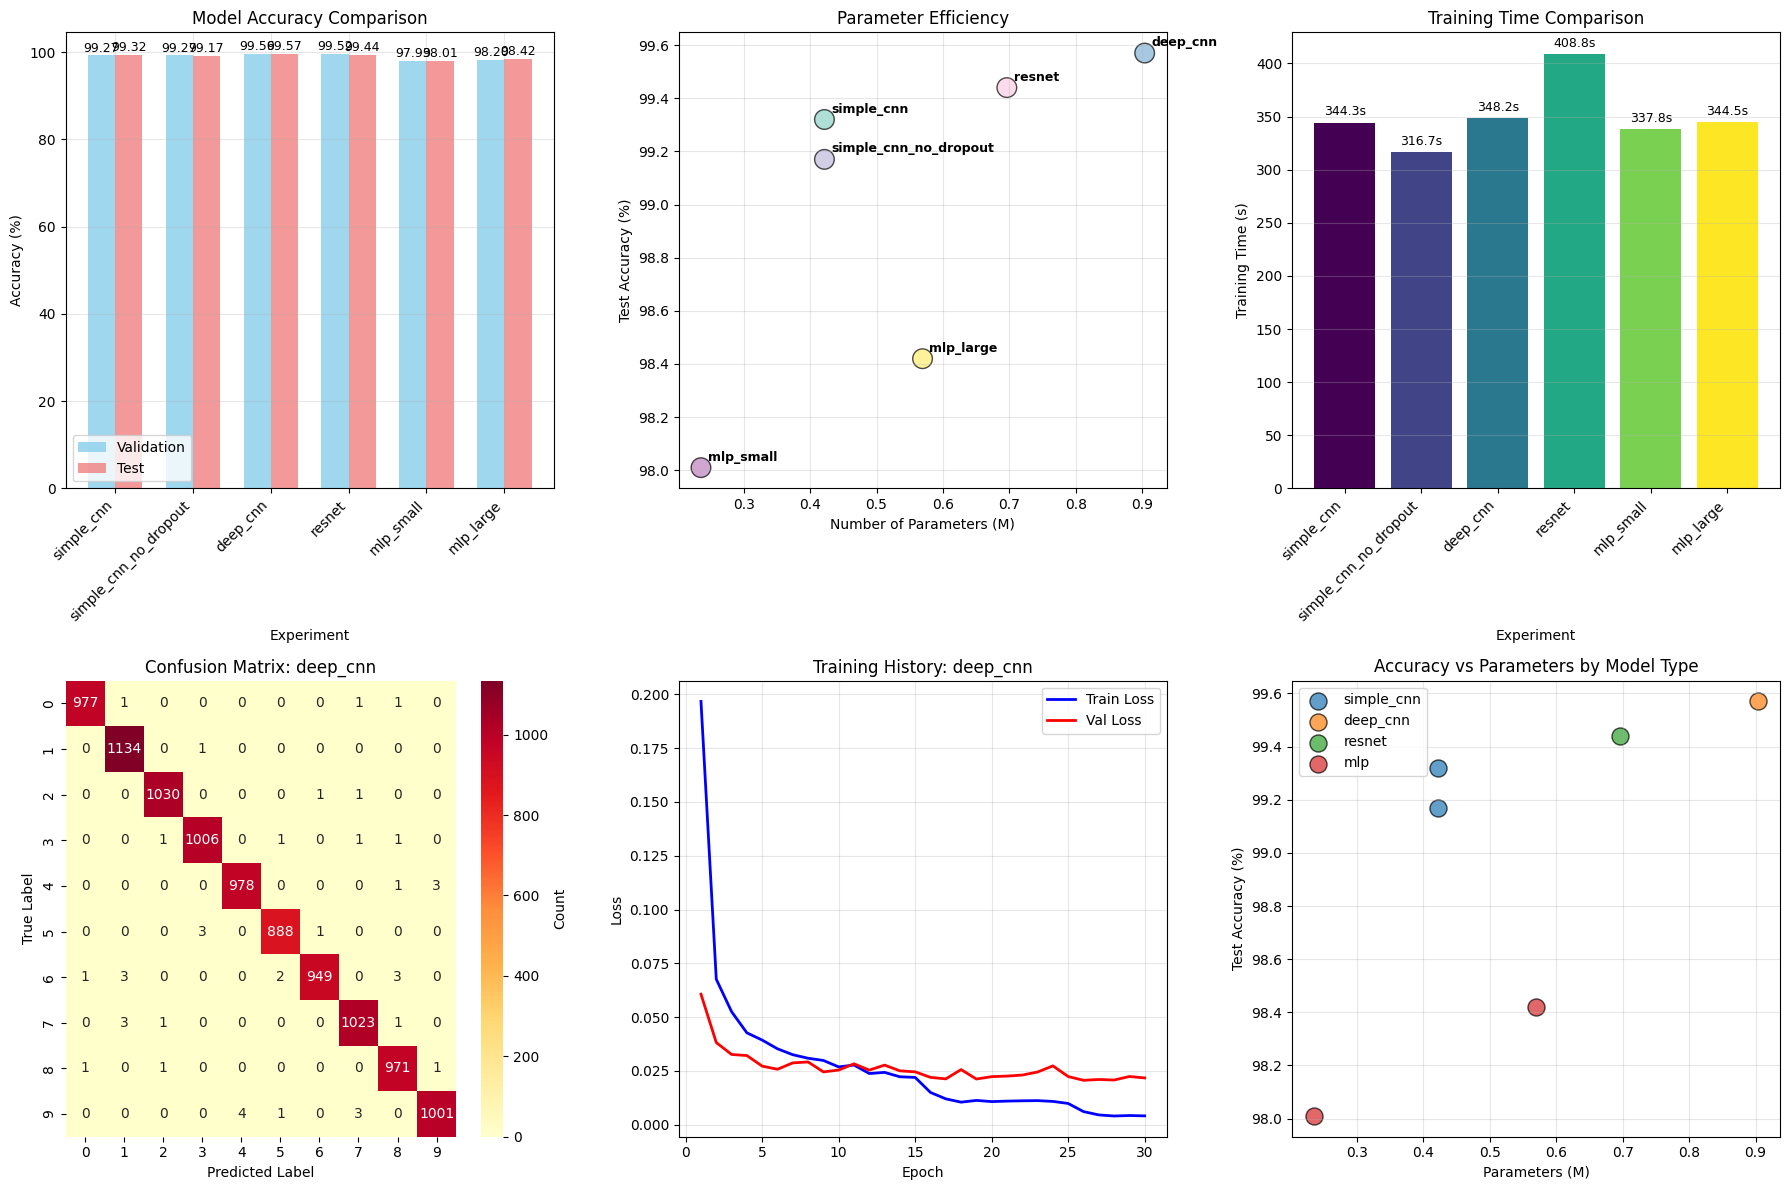


MODEL COMPARISON SUMMARY
           Experiment      Model  Test Accuracy (%)  Validation Accuracy (%)  Training Time (s)  Parameters (M)  Trainable Parameters (M)
           simple_cnn simple_cnn              99.32                99.266667         344.282473        0.421642                  0.421642
simple_cnn_no_dropout simple_cnn              99.17                99.266667         316.723626        0.421642                  0.421642
             deep_cnn   deep_cnn              99.57                99.558333         348.224710        0.903402                  0.903402
               resnet     resnet              99.44                99.516667         408.794604        0.696042                  0.696042
            mlp_small        mlp              98.01                97.933333         337.796143        0.235914                  0.235914
            mlp_large        mlp              98.42                98.200000         344.500087        0.569226                  0.569226

BEST MO

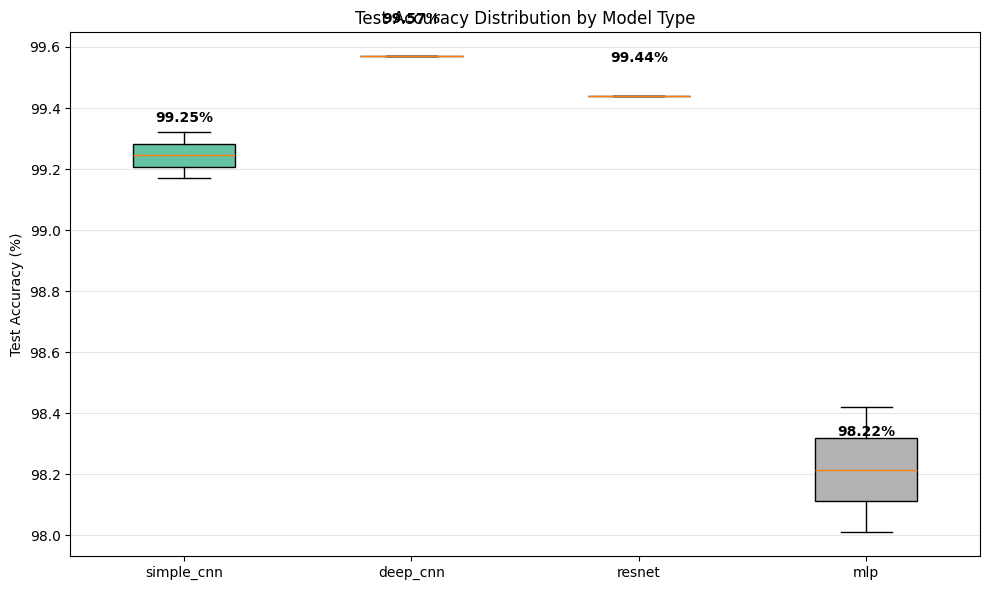

In [22]:
# Generate comprehensive comparison
print("\nGenerating comprehensive comparison analysis...")
comparison_df = comparator.plot_comparison()

# Plot performance by model type
print("\nAnalyzing performance by model type...")
comparator.plot_model_performance_by_type()